# Assignment 4b - Graph Convolutional Networks
## Deep Learning Course - Vrije Universiteit Amsterdam, 2022

#### Instructions on how to use this notebook:

This notebook is hosted on Google Colab. To be able to work on it, you have to create your own copy. Go to *File* and select *Save a copy in Drive*.

You can also avoid using Colab entirely, and download the notebook to run it on your own machine. If you choose this, go to *File* and select *Download .ipynb*.

The advantage of using Colab is that you can use a GPU. You can complete this assignment with a CPU, but it will take a bit longer. Furthermore, we encourage you to train using the GPU not only for faster training, but also to get experience with this setting. This includes moving models and tensors to the GPU and back. This experience is very valuable because for many interesting models and large datasets (like large CNNs for ImageNet, or Transformer models trained on Wikipedia), training on GPU is the only feasible way.

The default Colab runtime does not have a GPU. To change this, go to *Runtime - Change runtime type*, and select *GPU* as the hardware accelerator. The GPU that you get changes according to what resources are available at the time, and its memory can go from a 5GB, to around 18GB if you are lucky. If you are curious, you can run the following in a code cell to check:

```sh
!nvidia-smi
```

Note that despite the name, Google Colab does  not support collaborative work without issues. When two or more people edit the notebook concurrently, only one version will be saved. You can choose to do group programming with one person sharing the screen with the others, or make multiple copies of the notebook to work concurrently.

**Submission:** Upload your notebook in .ipynb format to Canvas. The code and answers to the questions in the notebook are sufficient, no separate report is expected. 

In [ ]:
!nvidia-smi

Fri Dec 23 13:10:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Introduction

Graphs are very useful data structures that allow us to represent sets of entities and the way they are related among each other. In a graph, entities are also known as *nodes*, and any link between entities is also called an *edge*.

Examples of real world objects that can be modeled as graphs are social networks, where entities are people and relations denote friendship; and molecules, where entities are atoms and relations indicate a bond between them.

There has been increased interest in the recent years in the application of deep learning architectures to graph-structured data, for tasks like predicting missing relations between entities, classifying entities, and classifying graphs. This interest has been spurred by the introduction of Graph Convolutional Networks (GCNs).

In this assignment, you will implement and experiment with one of the first versions of the GCN, proposed by Thomas Kipf and Max Welling in their 2017 paper, [Semi-supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907). In particular, the goals of this assignment are to

- Understand how GCNs are formulated
- Implement the GCN using PyTorch
- Train and evaluate a model for semi-supervised node classification in citation networks
- Train and evaluate a model for binary classification of molecules

### Representing graphs

Suppose we have the following graph:

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/01-graph.png" width="200">

This is an undirected graph (since the edges have no specified direction) with 4 nodes. One way to represent the connectivity structure of the graph is by means of the **adjacency matrix**. The $i$-th row of the matrix contains a 1 in the $j$-th column, if nodes $i$ and $j$ are connected. For an undirected graph like the one above, this means that the adjacency matrix

- Is symmetric (e.g. an edge between 0 and 2 is equivalent as an edge between 2 and 0)
- Is square, of size $n\times n$ where $n$ is the number of nodes

The adjacency matrix for the graph above is then the following:

$$
A =
\begin{bmatrix}
0 & 0 & 1 & 0 \\ 
0 & 0 & 1 & 0 \\
1 & 1 & 0 & 1 \\
0 & 0 & 1 & 0
\end{bmatrix}
$$

A second matrix of interest is the **degree matrix**. This is a diagonal matrix where the $i$-th element of the diagonal indicates the number of edges connected to node $i$. Note that these can be obtained from $A$ by summing across the columns, or the rows. For our example, the degree matrix is

$$
D = \begin{bmatrix}
1 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\
0 & 0 & 3 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

For specific applications, each node in the graph will have an associated vector of features $x\in\mathbb{R}^c$. If our graph is a social network, then the vector of features can contain information like age, location, and musical tastes, in a specific numeric format. In the case of a molecule, the node could represent an atom and have features like the atomic mass, etc. We can lay out the features in a matrix $X\in\mathbb{R}^{n\times c}$, so that the feature vector for node $i$ is in the $i$-th row.

### Loading a citation network

To move to a real world example, we will start with the Cora dataset. This dataset represents a citation network, where nodes are scientific publications, edges denote citations between them, and features are a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) extracted from their contents.

This graph contains labels for nodes, that represent a specific topic. We will use these for a node classification task.

To easily load it, we will use [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html) (PyG), a deep learning library for graph-structured data.

In [3]:
# Install PyTorch Geometric
import torch
try:
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version.
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric
    import torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 9.4 MB 7.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 4.5 MB 7.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 6.6 MB/s 
     |████████████████████████████████| 280 kB 63.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=fb6da094fb3690fc39cda70c25c7a0e87df2523797fe455cecb512f53a0a4f13
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attemptin

In [1]:
import torch
import torch_geometric

We can now use the library to download and import the dataset. Initializing the `Planetoid` class returns a `Dataset` object that can contain multiple graphs. In this task we will only use the `Cora` dataset (the citation network) and hence, we will select only the first element.

In [2]:
from torch_geometric.datasets import Planetoid
data = Planetoid(root='data/Planetoid', name='Cora')[0]

Processing...
Done!



#### Question 1 (0.25 pt)

The `data` object is an instance of the `Data` class in PyG. Check the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html) and report the following properties of the graph:

- Number of nodes
- Number of edges 
- The dimension $c$ of the feature vectors $x\in\mathbb{R}^c$
- The number of targets for the classification task

In [3]:
# Number of nodes
print(f"Number of Nodes: {data.num_nodes}")
# Number of edges
print(f"Number of Edges: {data.num_edges}")
# The dimension 𝑐 of the feature vectors  𝑥∈ℝ𝑐
node_features = data.num_node_features
print(f"Dimension 𝑐 of the feature vectors  𝑥∈ℝ𝑐: {node_features}")
# The number of targets for the classification task
num_classes = data.y.unique().size()[0]
print(f"Number of Classes: {num_classes}")

Number of Nodes: 2708
Number of Edges: 10556
Dimension 𝑐 of the feature vectors  𝑥∈ℝ𝑐: 1433
Number of Classes: 7


#### Question 2 (0.25 pt)

In PyG, edges are provided in a tensor of shape (2, number of edges). You can access it via `data.edge_index`. Each column in this tensor contains the IDs for two nodes that are connected in the graph.

We saw that in an undirected graph, an edge between nodes $i$ and $j$ adds a value of 1 to positions $(i, j)$ and $(j, i)$ of the adjacency matrix. Is this also true for the edge index? That is, if there is an edge $(i, j)$ in `data.edge_index`, is there also an edge for $(j, i)$? This is important to know for the next steps of the implementation.

In [4]:
import numpy as np
# Your answer here
print(data.edge_index)
adjacency_matrix= np.zeros((2708,2708), dtype = int) 
print(type(data.edge_index[0]))

# transform the matrix to adjacency matrix
for i in range(len(data.edge_index[0])):
    row = data.edge_index[0][i]
    col = data.edge_index[1][i]
    adjacency_matrix[row][col] = 1
    
res = (adjacency_matrix==adjacency_matrix.T).all()
# print the result
print(res)


tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
<class 'torch.Tensor'>
True


We observe that if edge (i,j) is in the adjacency matrix, then edge (j,i) is also in the matrix, which means the graph is undirected graph.

#### Question 3 (0.5 pt)

In graphs, especially large ones, the adjacency matrix is **sparse**: most entries are zero. Sparse matrices allow for efficient storage and computation.

To prepare and pre-process sparse matrices, we will use [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html). Once the matrices are ready, we will convert them to PyTorch tensors.

We will use the [Sparse COO format](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)). We encourage you to first get familiar with how it works after continuing with the assignment.

- Use the [`scipy.sparse.coo_matrix()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) function to build the adjacency matrix. Think of what arguments are needed, and how you can obtain them from the graph data loaded above.
- Use the `sum()` method of sparse matrices, together with `scipy.sparse.diags()`, to compute the [degree matrix](https://en.wikipedia.org/wiki/Degree_matrix) using the definition above.

Both resulting matrices must be sparse of type `float32`.

In [5]:
from scipy.sparse import coo_matrix
from scipy.sparse import diags
print(data.edge_index)

# build the adjacency matrix
coo = coo_matrix(adjacency_matrix, dtype=float)
 
# compute the degree matrix
degrees = coo.sum(axis=1).flatten().A
diag_matrix = diags(degrees, list(range(len(degrees))), dtype=float)


tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])


You might wonder why we suggest to use a scipy sparse matrix, while also PyTorch supports them. The reason is that in the next step, we will be multiplying two sparse matrices, an operation not supported in PyTorch. PyTorch only allows multiplying a sparse matrix with a dense one, something which we will be doing at a later stage.



### The Graph Convolutional Network

The goal of the graph convolution is to take the feature vectors of all nodes $X\in\mathbb{R}^{n\times c}$, and propagate them along the existing edges, to obtain updated representations $Z\in\mathbb{R}^{n\times d}$.


The GCN is initially motivated as performing a convolution, similarly as it is done in CNNs for images, for graph-structured data. In Kipf and Welling (2017), a theoretical derivation leads to the following formula:

$$
Z = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}XW
$$

where

- $W\in\mathbb{R}^{c\times d}$ is a matrix of parameters to be learned via gradient descent
- $\tilde{A} = A + I_n$, where $I_n$ is an $n\times n$ identity matrix
- $\tilde{D}$ is the degree matrix computed with $\tilde{A}$ as the adjacency matrix

If we define $\hat{A} = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$, the graph convolution can be written as $Z = \hat{A}XW$.

#### Question 4 (0.25 pt)

Given the formula for the GCN, explain why it operates by propagating feature vectors across the graph. To answer this, it might be useful to recall the definitions of the adjacency and degree matrices, and how they are involved in the formula.

To understand $\mathbf{\hat{A}} = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$, let us look at each multiplication individually. First 
$$
\left(\tilde{D}^{-\frac{1}{2}}\tilde{A}\right)_{ij} = \sum_{k=1}^N \tilde{D}^{-\frac{1}{2}}_{ik} \tilde{A}_{kj} = \tilde{D}^{-\frac{1}{2}}_{ii} \tilde{A}_{ij}
$$
This is because $\tilde{D}$ is a diagonal matrix, that is, it only has non-zero entries on its diagonal, thus reducing the sum to a single term. This term can be interpreted as scaling the strength of each outgoing connection from node $i$ by the number of outgoing connections node $i$ has. Now assigning $A' = \tilde{D}^{-\frac{1}{2}} \tilde{A}$,
$$
\left(A'\tilde{D}^{-\frac{1}{2}}\right) = \sum_{k=1}^N A'_{ik}\tilde{D}^{-\frac{1}{2}}_{kj} = A'_{ij}\tilde{D}^{-\frac{1}{2}}_{jj}
$$

Again this has the interpretation of scaling each incoming connection to node $j$ by $1/\sqrt{d_j}$. Therefore, the term $\mathbf{\hat{A}}_{ij}$ is $d_i^{-1/2}d_j^{-1/2}A_{ij}$ where $d_k$ is the degree for node $k$. This is non-zero only where nodes $i$ and $j$ are connected, or $i = j$ since $\tilde{A} = I_n + A$. 

$$
\left(\mathbf{\hat{A}}X\right)_{ij} = \sum_{k=1}^N \mathbf{\hat{A}}_{ik}X_{kj}
$$
This has the interpretation of computing a weighted sum of the $j$th attribute of all nodes connected to node $i$, weighted by the $\mathbf{\hat{A}}$ attributes described above. This yields a matrix of dimensions $n \times c$, the original dimension $X$. 

Now taking the final multiplication against the weight matrix $W$ is effectively a normal fully-connected layer between this weighted sum of attributes and the next layer. 

Because this uses a single adjacency hop, it can only provide convolutions for a node to its direct neighbors. Stacking these layers allow for wider dependencies, similar to how stacking convolutional layers yields richer features. 

#### Question 5 (0.5 pt)

Compute the **normalized adjacency matrix** $\hat{A}$. The result should be a sparse matrix.

In [6]:
from scipy.sparse import identity
a_tilde = coo + identity(coo.shape[0])
a_hat = (diag_matrix.power(-0.5) @ a_tilde @ diag_matrix.power(-0.5)).tocoo()

#### Question 6 (0.5 pt)

So far we have used scipy to build and compute sparse matrices. Since we want to train a GCN with PyTorch, we need to convert $\hat{A}$ into a sparse PyTorch tensor. You can do this with the [`torch.sparse_coo_tensor()`](https://pytorch.org/docs/stable/generated/torch.sparse_coo_tensor.html) function, making sure to specify `torch.float` as the type.

In [7]:
# Your answer here
indices = np.vstack((a_hat.row, a_hat.col))
a_hat_torch = torch.sparse_coo_tensor(indices, a_hat.data, dtype=torch.float)

#### Question 7 (0.5 pt)

We now have all the ingredients to build a GCN layer. Implement a class (inheriting from `torch.nn.Module`) with a learnable matrix of weights $W\in\mathbb{R}^{c\times d}$. Make sure to

- Call this class `GCNLayer`
- The `__init__()` constructor should take as argument the number of input and output features.
- Use `torch.nn.init.kaiming_uniform_` to initialize $W$.
- Define the `forward` method, which takes as input $X$ and $\hat{A}$ and returns $Z$. Note that multiplications involving the sparse matrix $\hat{A}$ have to be done with `torch.spmm`. 

Once you have implemented the class, instantiate a layer with the correct number of input features for the Cora dataset, and a number of output features of your choice. Do a forward pass and report the shape of the output tensor.

In [8]:
# Your answer here
class GCNLayer(torch.nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    W = torch.empty((in_features, out_features))
    self.W = torch.nn.Parameter(torch.nn.init.kaiming_uniform_(W), requires_grad=True)
  
  def forward(self, X, A_hat):
    X = torch.spmm(A_hat, X)
    #Z = torch.spmm(X, self.W)
    Z = torch.matmul(X, self.W)
    return Z

gcn_layer = GCNLayer(node_features, 12)
result = gcn_layer(data.x, a_hat_torch)
print(result.size())

torch.Size([2708, 12])


#### Question 8 (0.5 pt)

As we have seen so far, the GCN layer implements a special type of linear transformation of the inputs. However, it is often beneficial in deep learning to stack multiple, non-linear transformations of the input features. Implement a second module class for a model with two GCN layers (use the module you implemented in the previous question).

- Call this class `GCN`
- The constructor must now take as input the number of input features, the output dimension of the first layer (this is the hidden layer), and the output dimension of the output layer.
- In the forward pass, add a ReLU activation function after the first layer.

In [74]:
# Your answer here
class GCN(torch.nn.Module):
  def __init__(self, in_features, h_size, out_features):
    super().__init__()
    self.gcn1 = GCNLayer(in_features, h_size)
    self.gcn2 = GCNLayer(h_size, out_features)
    self.relu = torch.nn.ReLU()
  
  def forward(self, X, A_hat):
    assert not torch.isnan(X).any()
    assert not torch.isnan(A_hat).any()
    X = self.gcn1(X, A_hat)
    assert not torch.isnan(X).any()
    X = self.relu(X)
    assert not torch.isnan(X).any()
    Z = self.gcn2(X, A_hat)
    assert not torch.isnan(Z).any()
    return Z

### GCNs for semi-supervised node classification

Now that we have a GCN with two layers, we can test its performance in a node classification task. We will pass the input node features $X$ through the GCN layers, and the output will be of size $n\times k$ where $k$ is the number of classes (which you found in question 1). The label denotes the topic an article in the citation network belongs to (e.g. physics, computer science, etc.).

#### Question 9 (1.5 pt)

Note that the `data` object contains all labels (for all splits) in `data.y`, and binary masks for the train, validation, and test splits in `data.train_mask`, `data.val_mask`, and `data.test_mask`, respectively. These masks are the same size as `data.y`, and indicate which labels belong to which split.

- Create a GCN with two layers (using the class from the previous question), with 32 as the hidden dimension, and the number of output features equal to the number of classes in the Cora dataset.

- Use the Adam optimizer with a learning rate of 0.01.

- Implement a training loop for the GCN. At each step, pass $X$ and $\hat{A}$ to the GCN to obtain the logits. Compute the mean cross-entropy loss **only for the training instances**, using the binary masks.

- After each training step, evaluate the accuracy for the validation instances.

- Train for 100 epochs. Once training is finished, plot the training loss and validation accuracy (in a graph in function of the epoch number), and report the accuracy in the test set.

You should obtain an accuracy over 75% on both the validation and test sets. You can also compare your results with the original paper, which also contains results for the Cora dataset. Give a brief discussion on the results of your experiments.

Note that in contrast with other tasks, like image classification on some datasets, we don't use mini-batches here. The whole matrix of features and the adjacency is passed to the GCN in one step.

In [75]:
# Your answer here
# Initialize GCN
num_classes = data.y.unique().size()[0]
num_hidden = 32
num_features = data.num_node_features
torch.random.manual_seed(3)
gcn = GCN(num_features, num_hidden, num_classes)

n_epochs = 100

optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

all_losses = []
val_accuracies = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gcn = gcn.to(device)
data = data.to(device)
a_hat_torch = a_hat_torch.to(device)

for epoch in range(n_epochs):
  print(epoch)
  running_loss = 0
  # Zero your gradients for every batch!
  optimizer.zero_grad()

  # Make predictions for this batch
  pred = gcn(data.x, a_hat_torch)
  # Compute the loss and its gradients
  loss = loss_fn(pred[data.train_mask], data.y[data.train_mask])
  loss.backward()

  # Adjust learning weights
  optimizer.step()
  running_loss += loss.mean().item()
  all_losses.append(running_loss)
  print(f'Running loss: {running_loss}')

  
  preds = gcn(data.x, a_hat_torch)
  correct = 0
  for i, pred in enumerate(preds):
    if not data.val_mask[i]:
      continue
    corr = data.y[i]
    if torch.argmax(pred) == corr:
      correct += 1
  accuracy = correct/data.val_mask.sum()
  print(f'Accuracy: {accuracy}')
  val_accuracies.append(accuracy.cpu())

preds = gcn(data.x, a_hat_torch)
correct = 0
for i, pred in enumerate(preds):
  if not data.test_mask[i]:
    continue
  corr = data.y[i]
  if torch.argmax(pred) == corr:
    correct += 1
test_accuracy = correct/data.test_mask.sum()
print(f'Test Accuracy: {test_accuracy}')

0
Running loss: 4.083870887756348
Accuracy: 0.12000000476837158
1
Running loss: 2.726768970489502
Accuracy: 0.18200001120567322
2
Running loss: 1.9883220195770264
Accuracy: 0.24000000953674316
3
Running loss: 1.4490110874176025
Accuracy: 0.3320000171661377
4
Running loss: 1.0632437467575073
Accuracy: 0.4180000126361847
5
Running loss: 0.7939671277999878
Accuracy: 0.492000013589859
6
Running loss: 0.6062090992927551
Accuracy: 0.5400000214576721
7
Running loss: 0.469176709651947
Accuracy: 0.5720000267028809
8
Running loss: 0.3651857078075409
Accuracy: 0.5920000076293945
9
Running loss: 0.2845751941204071
Accuracy: 0.6160000562667847
10
Running loss: 0.22210974991321564
Accuracy: 0.6380000114440918
11
Running loss: 0.17476902902126312
Accuracy: 0.6640000343322754
12
Running loss: 0.13929487764835358
Accuracy: 0.6780000329017639
13
Running loss: 0.11216000467538834
Accuracy: 0.6820000410079956
14
Running loss: 0.0911697968840599
Accuracy: 0.690000057220459
15
Running loss: 0.07443634420633

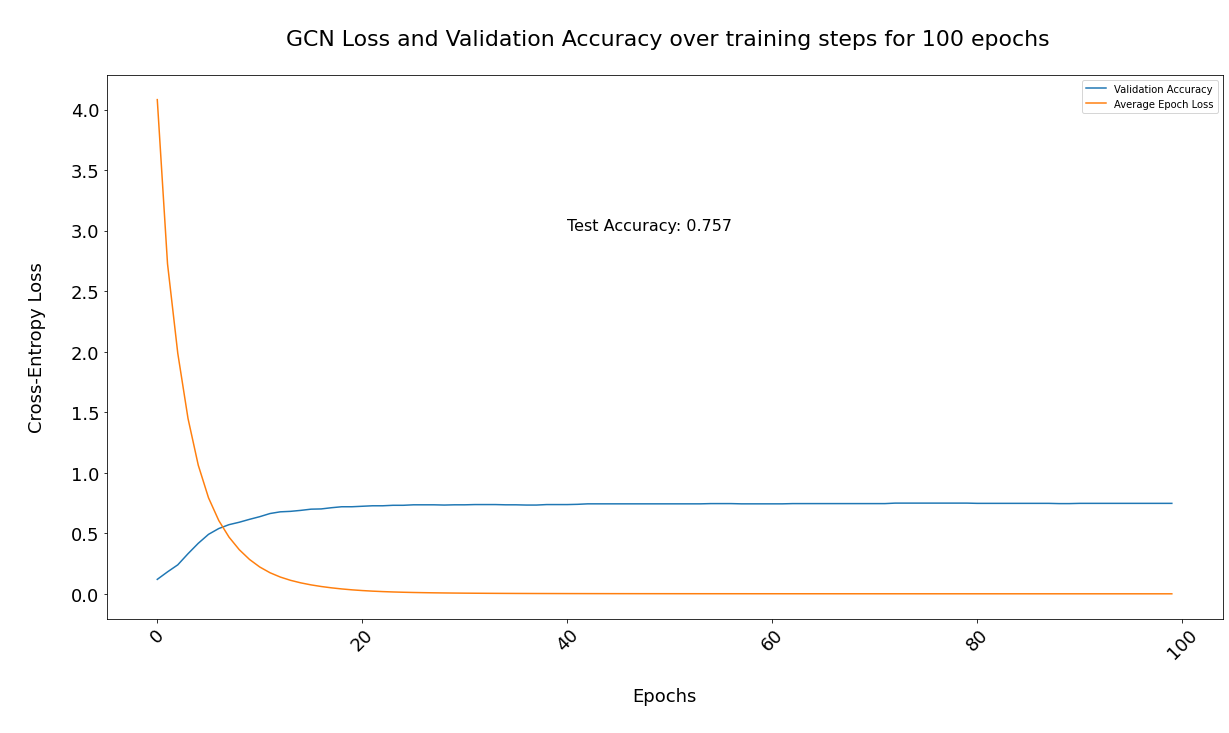

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(list(range(len(val_accuracies))), val_accuracies, label='Validation Accuracy')
plt.plot(list(range(len(all_losses))), all_losses, label='Average Epoch Loss')
plt.title('Average training loss and validation accuracy per epoch')
plt.title("\n GCN Loss and Validation Accuracy over training steps for 100 epochs\n", size = 22)
plt.ylabel("\nCross-Entropy Loss\n", size = 18)
plt.xlabel("\nEpochs\n", size = 18)
plt.xticks(size = 18, rotation = 45)
plt.yticks(size = 18)
plt.annotate(f"Test Accuracy: {round(test_accuracy.item(),6)}", xy = (40,3), size = 16)
plt.legend()
plt.show()

On the Cora dataset we obtained a validation accuracy of 74.80% after 100 epochs (75.00% maximum value after ca. 50 epochs), and on the test set a performance of 75.70%. We observe a quick plateauing of accuracy and loss values, indicating that the model stops learning efficiently before the end of the 100 epochs.

#### Question 10 (0.5 pt)

The paper introduces GCNs as a way to solve a *semi-supervised* classification problem.

- What makes this problem semi-supervised?
- What is the proportion of labeled data used for training with respect to labeled data in the validation and test sets? What is difference in this context with other benchmark tasks in machine learning, like image classification with MNIST?
- Why do you think the GCN performs well in this semi-supervised scenario?

In [ ]:
print(f"Number of Train Nodes: {len(data.train_mask.nonzero())}")
print(f"Number of Test Nodes: {len(data.test_mask.nonzero())}")
print(f"Number of Val Nodes: {len(data.val_mask.nonzero())}")


Number of Train Nodes: 140
Number of Test Nodes: 1000
Number of Val Nodes: 500


Only a subset of nodes is revealed to the model as labeled (through train_mask), essentially treating the other nodes as unlabeled. The gradient update is only performed based on the labeled nodes, i.e., in a **supervised** manner, but the connected graph structure (represented by the adjacency matrix) also allows to transmit gradient information from the labeled nodes to the unlabeled nodes. As the representations of the labeled nodes again depend on the representations of the unlabeled nodes, the model is forced to learn "correct" representations also of the unlabeled nodes. The model is thus capable to learn representations for unlabeled nodes without explicitly being trained on these nodes; the model thus also partly learns in an **unsupervised** fashion. As the GCN is able to learn both in a supervised and unsupervised way, the GCN is suitable to solve **semi-supervised** classification tasks.

In the dataset at hand, only 140 labeled nodes are used for training, while 500 nodes are used for validation (e.g., tuning), and 1000 nodes can be used for testing. This demonstrates that not even 10% of graph nodes are needed to obtain a meaningful classification of labeled and unlabeled nodes in a GCN. Other commonly used neural network architectures would require a far higher amount of training examples in order to achieve comparable results. 

It is due to the nature of the graph structure, which involves propagating information between labeled and unlabeled nodes, that allows the GCN to perform so particularly well in semi-supervised scenarios, even with such a small portion of labeled training examples. 



### Loading a dataset of proteins

In the previous sections you learned how to pass the adjacency matrix of a graph with a couple of thousand of nodes, to classify each node with a particular label. A different and useful application of GCNs is graph classification.

In contrast with the previous part, where there was a single, big graph, in graph classification we have multiple graphs, and each graph can be assigned a label. In this part of the assignment you will implement a classifier for proteins.

[Proteins](https://en.wikipedia.org/wiki/Protein_(nutrient)) are parts of the buildings block of life. They consist of chains of amino acids, and can take many shapes. In the PROTEINS dataset, proteins are represented as graphs, where the nodes are amino acids, and an edge between them indicates that they are 6 [Angstroms](https://en.wikipedia.org/wiki/Angstrom) apart. All graphs have a binary label, where 1 means that the protein is not an enzyme.

We will start by loading and examining this dataset.

In [ ]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='data/TU', name='PROTEINS', use_node_attr=True)

Extracting data/TU/PROTEINS/PROTEINS.zip
Processing...
Done!


#### Question 11 (0.25 pt)

Unlike in the previous part, where we selected the first element returned by the loading function, note that here we get all the elements returned by `TUDataset()`. `dataset` is an interable object, that has some similar behaviors as a Python list: you can call `len()` on it, and you can takes slices from it.

Each element in `dataset` is a `Data` object containing a graph that represents a protein. This is the same type of object that we used in the previous part to store the Cora citation network.

Knowing this, answer the following:

- How many proteins (graphs) are there in `dataset`?
- Take any protein from `dataset`. How many nodes and edges does it contain? What is its label? How many features does each node have?

In [ ]:
# Your answer here
# Proteins (graphs) in dataset:
print(f'# Proteins in dataset: {len(dataset)}')

# Nodes and edges in random protein network
prot = dataset[10]
print(f'# Nodes in protein: {prot.num_nodes}')
print(f'# Edges in protein: {prot.num_edges}')

# Proteins in dataset: 1113
# Nodes in protein: 20
# Edges in protein: 64


#### Question 12 (0.5 pt)

To properly train and evaluate our model, we need training, validation, and test splits.

For reproducibility purposes, we generate a random tensor of indices for you. Use it to extract the three splits from `dataset`.

For training, take 80% of the indices (starting from the first element in `indices`), then the following 10% for validation, and the remaining 10% for testing. You can use the indices to index `dataset`.

Call the resulting splits `train_dataset`, `valid_dataset`, and `test_dataset`.

In [ ]:
# Don't erase the following three lines
import torch
torch.random.manual_seed(0)
indices = torch.randperm(len(dataset))

# Your answer here
num_training = round(len(dataset)*0.8)
num_validation = round(len(dataset)*0.1)

train_dataset = dataset[indices[0:num_training]]
valid_dataset = dataset[indices[num_training:num_training+num_validation]]
test_dataset = dataset[indices[num_training+num_validation:]]

# Remove 4 problem Graphs for the Train Data and 1 for Valid (Caused NaNs):
train_mask = torch.ones(len(train_dataset))
for i in [33, 263, 543, 752]:
  train_mask[i] = 0
train_dataset = train_dataset[train_mask == 1]

val_mask = torch.ones(len(valid_dataset))
val_mask[60] = 0
valid_dataset = valid_dataset[val_mask == 1]


### Working with a batch of graphs

When working with the Cora dataset, you used the information in `data.edge_index` to build the sparse normalized adjacency matrix $\hat{A}$ that is required by the GCN. We could do something similar here: for each graph, we build $\hat{A}$, and pass it to the GCN. However, if the number of graphs is big, this can really slow down training.

To avoid this, we will resort to a very useful trick that also allows us to reuse the same GCN you implemented previously. The trick makes it possible to do a forward pass through the GCN for multiple, disconnected graphs at the same time (instead of only one), much like when you train with mini-batches for other kinds of data.

Let's first revisit the propagation rule of the GCN, $Z = \hat{A}XW$, with an illustration (we have omitted the cells of $X$ and $W$ for clarity):

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/02-gcn-forward.png">

If we have multiple graphs, we can still use the same propagation rule, if we

- Set $\hat{A}$ to be a block diagonal matrix, where the blocks are the different adjacency matrices of the graphs
- Concatenate the feature matrices along the first dimension

This is illustrated in the following figure, for a batch of 3 graphs. Note that the elements outside of the blocks are zero.

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/02-gcn-batch-forward.png">

The resulting adjacency matrix $\hat{A}_B$ can also be built as a sparse matrix, and once we have it together with the concatenated matrix of features, the computation of the graph convolution is exactly the same as before. Note how this trick also allows us to process graphs with different sizes and structures.


#### Question 13 (0.5 pt)


Just as the citation network, the graphs in each of the datasets you created in Question 12 also have an `edge_index` attribute, which can be used to compute the normalized adjacency matrix $\hat{A}$, for each graph.

Reusing your code for Questions 3 and 5, define a function `get_a_norm()` that takes as input an element of a dataset (e.g. `train_dataset[0]`), and returns a `scipy.sparse` matrix containing $\hat{A}$.

Note that an element of a dataset has properties like `num_edges`, `num_nodes`, etc. which you can use here.

In [ ]:

# Your answer here
def get_a_norm(graph: torch_geometric.data.Data):
  adjacency_matrix = np.zeros((graph.num_nodes, graph.num_nodes), dtype = int) 

  for i in range(len(graph.edge_index[0])):
    row = graph.edge_index[0][i]
    col = graph.edge_index[1][i]
    adjacency_matrix[row][col] = 1

  coo = coo_matrix(adjacency_matrix)
  degrees = coo.sum(axis=1).flatten().A
  diag_matrix = diags(degrees, list(range(len(degrees))))
  a_tilde = coo + identity(coo.shape[0])
  a_hat = (diag_matrix.power(-0.5) @ a_tilde @ diag_matrix.power(-0.5)).tocoo()
  
  return a_hat


#### Question 14 (1 pt)

To prepare the batch of graphs, we need to collect multiple adjacency matrices, feature matrices, and labels.

When using the trick described in the last figure, we see that we have to keep track of when a graph starts and when it ends, so that we can later differentiate the outputs due to $X^{(0)}$, $X^{(1)}$, etc. To achieve this, we will additionally collect a 1D array of batch indices, one for each $X^{(i)}$.

The 1D array has as many elements as rows in $X^{(i)}$, and it is filled with the value $i$ (the position of $X^{(i)}$ in the batch):

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/03-batch-indices.png">

We will later concatenate all the 1D arrays along the first dimension, just as we will do with all the $X^{(i)}$.

Define a function `prepare_graphs_batch()` that takes as input a dataset (e.g. `train_dataset`), and does the following

- Create four empty lists:
  - `adj_matrices`
  - `feature_matrices`
  - `batch_indices`
  - `labels`
- Iterate over the input dataset, getting one graph at a time. At each step, use your function from Question 13 to append the adjacency matrix to `adj_matrices`, append the matrix of input features to `feature_matrices`, create the array of batch indices (as explained above) and append it to `batch_indices`, and append the label of the graph to `labels`. **Make sure to convert the label to float**.
- Once the loop is over, use `scipy.sparse.block_diag()` to build the block diagonal matrix $\hat{A}_B$. Convert it to the COO format, and then use your answer to Question 6 to turn it into a sparse PyTorch tensor.
- Use `torch.cat()` to concatenate the tensors in `feature_matrices` along the first dimension. Do this also for `batch_indices` and `labels`.
- Return the 4 tensors computed in the previous two items.

In [61]:
import numpy as np
from scipy.sparse import block_diag

# Your answer here
def prepare_graphs_batch(dataset):

  adj_matricies = []
  feature_matrices = []
  batch_indices = []
  labels = []

  for i, data in enumerate(dataset):
    adj_matricies.append(get_a_norm(data))
    feature_matrices.append(data.x)
    labels.append(data.y.float())
    batch_indices.append(torch.zeros(len(data.x), dtype = torch.int64)+i)

  a_hat_B = block_diag(adj_matricies).tocoo()
  indices = np.vstack((a_hat_B.row, a_hat_B.col))
  a_hat_B_torch = torch.sparse_coo_tensor(indices, a_hat_B.data, dtype=torch.float)

  feat_mat_cat = torch.cat(feature_matrices, axis = 0)
  batch_indices_cat = torch.cat(batch_indices, axis = 0)
  labels_cat = torch.cat(labels, axis = 0)

  return a_hat_B_torch, feat_mat_cat, batch_indices_cat, labels_cat

In [62]:

train_a_norm, train_features, train_batch_idx, train_labels = prepare_graphs_batch(train_dataset)
val_a_norm, val_features, val_batch_idx, val_labels = prepare_graphs_batch(valid_dataset)
test_a_norm, test_features, test_batch_idx, test_labels = prepare_graphs_batch(test_dataset)


Once your answer for the previous question is ready, you can run the next cell to prepare all the required information, for the train, validation, and test splits.

### GCNs for graph classification

We now have all the ingredients to pass a batch of graphs to a GCN. However, for each graph in the batch, the output $Z^{(i)}$ contains one row for each node in the graph. If the goal is to do classification at the graph level, we have to *pool* these vectors to then compute the required logits for classification.

This operation is similar as how pooling works in a CNN. We could consider taking the mean of the vectors, the sum, or use max-pooling. The difference with respect to CNNs is that in our case, we have a batch of graphs, each potentially with a different number of nodes.

To implement this specific pooling, we can use the scatter operation in the `torch_scatter` library, which comes when installing PyG. We will use it, together with the tensor of batch indices from the previous two questions, to pool the outputs of the GCN for each graph, into a single vector:

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/04-scatter.png">

You can check more details in the [documentation](https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html).

#### Question 15 (1.0 pt)

Implement a `GraphClassifier` module using PyTorch.

- The constructor should take as arguments the number of input features, the hidden dimension, and the number of classes.
- The model should contain a instance of the `GCN` module (as you implemented it in Question 8). Use the same value for the hidden dimension and the number of output features (recall that your `GCN` module from Question 8 has two GCN layers).
- The model should also contain a `torch.nn.Linear` layer, with the hidden dimension as the input features, and the number of classes as the output.
- The forward method receives the concatenated matrix of features, the sparse block diagonal adjacency matrix, and the batch indices (the latter is used when calling `scatter`).
- Use the following architecture in the forward pass:
  - GCN $\to$ ReLU $\to$ scatter (max) $\to$ Linear.

The output of the forward should be a 1D tensor (you might need to call `squeeze` to get rid of extra dimensions) containing the logits for all graphs in the batch, for the binary classification task.

In [ ]:

from torch_scatter import scatter

class GraphClassifier(torch.nn.Module):
  def __init__(self, in_features, hidden_size, num_classes):
    super().__init__()
    self.gcn = GCN(in_features, hidden_size, hidden_size)
    self.relu = torch.nn.ReLU()
    self.fc1 = torch.nn.Linear(hidden_size, num_classes)
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, X, adj_mat, batch_indices): 
    assert not torch.isnan(X).any()
    assert not torch.isnan(adj_mat).any()
    x = self.gcn(X, adj_mat)
    assert not torch.isnan(x).any()
    x = self.relu(x)
    x = scatter(x, batch_indices, 0)
    x = self.fc1(x)
    output = torch.squeeze(x)
    return output
    


#### Question 16 (1.5 pt)

Implement a training loop for the graph classifier. Use the data from Question 14 to train and evaluate the model.

We encourage you to use a GPU in this section for faster training. Note that if you change the runtime at this point, you must re-execute several of the cells above, including the ones that install PyG.

- Instantiate a classifier with 32 as the hidden dimension
- Use Adam with a learning rate of 1e-3.
- Use `torch.nn.BCEWithLogitsLoss` as the loss function.
- Train for 5,000 epochs. Once training is done, plot the loss curve and the accuracy in the validation set. Then report the accuracy in the test set.

**Note:** the logits from the output of the classifier come from a linear layer. To compute actual predictions for the calculation of the accuracy, pass the logits through `torch.sigmoid()`, and set the predicted values to 1 whenever they are greater than 0.5, and to 0 otherwise.

You should get an accuracy equal to or higher than 70% in the validation and test sets. Can you beat the [state-of-the-art](https://paperswithcode.com/sota/graph-classification-on-proteins)? Feel free to modify your architecture and experiment with it.

Discuss what you observe during training and your results.

In [26]:
# If your runtime is GPU-enabled, use .to(device) to move the model
# and all the relevant tensors to the GPU. You have to move tensors back to CPU
# when computing metrics like accuracy, using .cpu().

import time

# Helper function
def sigmoid(x):
  """Sigmoid helper function for computing the accuracy by hand"""
  return 1 / (1 + torch.exp(-x))

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

num_classes = 1
hidden_size = 32
in_features = train_features.size()[1]

n_epochs = 5000

gclassifier = GraphClassifier(in_features, hidden_size, num_classes)
optimizer = torch.optim.Adam(gclassifier.parameters(), lr=5e-03)
loss_fn = torch.nn.BCEWithLogitsLoss()

# Move to GPU
gclassifier.to(device)
train_a_norm = train_a_norm.to(device)
train_features = train_features.to(device)
train_batch_idx = train_batch_idx.to(device) #
train_labels = train_labels.to(device)
val_a_norm = val_a_norm.to(device)
val_features = val_features.to(device)
val_batch_idx = val_batch_idx.to(device) #
val_labels = val_labels.to(device)
all_losses = []

start = time.time()
# Run Training Loop
for epoch in range(n_epochs):

  running_loss = 0

  # Zero gradients for every batch
  optimizer.zero_grad()

  # Make predictions for this batch
  pred = gclassifier.forward(train_features, train_a_norm, train_batch_idx.type(torch.int64))

  # Compute the loss and its gradients
  loss = loss_fn(pred, train_labels)
  loss.backward()

  # Adjust learning weights
  optimizer.step()
  running_loss += loss.item()
  all_losses.append(running_loss)

  if epoch % 500 == 0:
    # Calculate Train accuracy
    correct = (sigmoid(pred).round() == train_labels).sum() # Working only with sigmoid helper function
    accuracy = correct / len(train_labels)

    # Calculate Val accuracy
    pred_val = gclassifier.forward(val_features, val_a_norm, val_batch_idx.type(torch.int64))
    val_correct = (sigmoid(pred_val).round() == val_labels).sum() # Working only with sigmoid helper function
    val_accuracy = val_correct / len(val_labels)
    print(f'Epoch {epoch} - Running loss: {running_loss}, Train Accuracy: {accuracy}, Val Accuracy: {val_accuracy}')

stop = time.time()

print(f"time needed: {stop - start}")

# Your answer here


Epoch 0 - Running loss: 21.373144149780273, Train Accuracy: 0.5925508141517639, Val Accuracy: 0.6272727251052856
Epoch 500 - Running loss: 0.5415264964103699, Train Accuracy: 0.7550790309906006, Val Accuracy: 0.7545454502105713
Epoch 1000 - Running loss: 0.534081757068634, Train Accuracy: 0.7471783757209778, Val Accuracy: 0.7636363506317139
Epoch 1500 - Running loss: 0.5193541049957275, Train Accuracy: 0.7607223391532898, Val Accuracy: 0.7727272510528564
Epoch 2000 - Running loss: 0.5163883566856384, Train Accuracy: 0.765237033367157, Val Accuracy: 0.7636363506317139
Epoch 2500 - Running loss: 0.520374059677124, Train Accuracy: 0.752821683883667, Val Accuracy: 0.7636363506317139
Epoch 3000 - Running loss: 0.5240050554275513, Train Accuracy: 0.7449210286140442, Val Accuracy: 0.781818151473999
Epoch 3500 - Running loss: 0.5268449783325195, Train Accuracy: 0.7663657069206238, Val Accuracy: 0.7454545497894287
Epoch 4000 - Running loss: 0.5060558915138245, Train Accuracy: 0.765237033367157,

## Tuning the Network

- Adding more GCN Layers
- Adding Batch Normalization
- Varying the LR
- Varying the hidden dimension


In [63]:

class GraphClassifier_tune(torch.nn.Module):
  def __init__(self, in_features, hidden_size, num_classes, normalize = False, no_layers = 2):
    super().__init__()

    self.normalize = normalize
    self.no_layers = no_layers
    self.gcn = GCN(in_features, hidden_size, hidden_size)
    self.gcn2 = GCN(hidden_size, hidden_size, hidden_size)
    self.gcn3 = GCN(hidden_size, hidden_size, hidden_size)
    self.relu = torch.nn.ReLU()
    self.norm = torch.nn.BatchNorm1d(hidden_size)
    self.norm2 = torch.nn.BatchNorm1d(hidden_size)
    self.fc1 = torch.nn.Linear(hidden_size, num_classes)
    self.sigmoid = torch.nn.Sigmoid()


  def forward(self, X, adj_mat, batch_indices): 

    # Apply GCN
    x = self.gcn(X, adj_mat)

    # Normalize
    if self.normalize:
      x = self.norm(torch.squeeze(x))
    else:
      pass

    # Add Layers (two each)
    if self.no_layers == 4:
      x = self.gcn2(x, adj_mat)

    elif self.no_layers == 6:
      x = self.gcn2(x, adj_mat)
      x = self.gcn3(x, adj_mat)

    # Nonlinearity
    x = self.relu(x)
    x = scatter(x, batch_indices, 0)

    # Normalize
    if self.normalize:
      x = self.norm2(torch.squeeze(x))
    else:
      pass
    
    # Linear layer
    x = self.fc1(x)
    output = torch.squeeze(x)
    return output


In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = ParameterGrid({"no_layers": [2, 4, 6], 
              "no_hidden": [32, 64, 128],
              "lr" : [0.001, 0.01],
              "norm" : [True, False]})

# Helper function
def sigmoid(x):
  """Sigmoid helper function for computing the accuracy by hand"""
  return 1 / (1 + torch.exp(-x))

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

start = time.time()
for params in param_grid:

  num_classes = int(max(train_labels))
  hidden_size = params['no_hidden']
  in_features = train_features.size()[1]
  layers = params['no_layers']
  lr = params['lr']
  norm = params['norm']

  n_epochs = 5000

  gclassifier = GraphClassifier_tune(in_features, hidden_size, num_classes, normalize = norm, no_layers = layers)
  optimizer = torch.optim.Adam(gclassifier.parameters(), lr=lr)
  loss_fn = torch.nn.BCEWithLogitsLoss()

  # Move to GPU
  gclassifier.to(device)
  train_a_norm = train_a_norm.to(device)
  train_features = train_features.to(device)
  train_batch_idx = train_batch_idx.to(device) #
  train_labels = train_labels.to(device)
  val_a_norm = val_a_norm.to(device)
  val_features = val_features.to(device)
  val_batch_idx = val_batch_idx.to(device) #
  val_labels = val_labels.to(device)
  all_losses = []

  # Run Training Loop
  for epoch in range(n_epochs):

    running_loss = 0

    # Zero gradients for every batch
    optimizer.zero_grad()

    # Make predictions for this batch
    pred = gclassifier.forward(train_features, train_a_norm, train_batch_idx.type(torch.int64))

    # Compute the loss and its gradients
    loss = loss_fn(pred, train_labels)
    loss.backward()

    # Adjust learning weights
    optimizer.step()
    running_loss += loss.item()
    all_losses.append(running_loss)

  # Calculate Train accuracy
  correct = (sigmoid(pred).round() == train_labels).sum()
  accuracy = correct / len(train_labels)

  # Calculate Val accuracy
  pred_val = gclassifier.forward(val_features, val_a_norm, val_batch_idx.type(torch.int64))
  val_correct = (sigmoid(pred_val).round() == val_labels).sum()
  val_accuracy = val_correct / len(val_labels)
  print(f'GCN Layers: {layers}, Hidden dim: {hidden_size}, LR: {lr}, Normalize: {norm} \n- Running loss: {round(running_loss,7)}, Train Accuracy: {round(accuracy.item(),5)}, Val Accuracy: {round(val_accuracy.item(),5)} \n')

stop = time.time()

print(f"time needed: {stop - start}")


GCN Layers: 2, Hidden dim: 32, LR: 0.001, Normalize: True 
- Running loss: 0.4358757, Train Accuracy: 0.79007, Val Accuracy: 0.68182 

GCN Layers: 2, Hidden dim: 32, LR: 0.001, Normalize: False 
- Running loss: 0.5138417, Train Accuracy: 0.75734, Val Accuracy: 0.8 

GCN Layers: 4, Hidden dim: 32, LR: 0.001, Normalize: True 
- Running loss: 0.1138684, Train Accuracy: 0.96388, Val Accuracy: 0.66364 

GCN Layers: 4, Hidden dim: 32, LR: 0.001, Normalize: False 
- Running loss: 0.5292078, Train Accuracy: 0.75282, Val Accuracy: 0.8 

GCN Layers: 6, Hidden dim: 32, LR: 0.001, Normalize: True 
- Running loss: 0.0762756, Train Accuracy: 0.97291, Val Accuracy: 0.54545 

GCN Layers: 6, Hidden dim: 32, LR: 0.001, Normalize: False 
- Running loss: 0.5121213, Train Accuracy: 0.75395, Val Accuracy: 0.80909 

GCN Layers: 2, Hidden dim: 64, LR: 0.001, Normalize: True 
- Running loss: 0.401168, Train Accuracy: 0.80587, Val Accuracy: 0.68182 

GCN Layers: 2, Hidden dim: 64, LR: 0.001, Normalize: False 
-

Raw output: 
```
GCN Layers: 2, Hidden dim: 32, LR: 0.001, Normalize: True 
- Running loss: 0.4358757, Train Accuracy: 0.79007, Val Accuracy: 0.68182 

GCN Layers: 2, Hidden dim: 32, LR: 0.001, Normalize: False 
- Running loss: 0.5138417, Train Accuracy: 0.75734, Val Accuracy: 0.8 

GCN Layers: 4, Hidden dim: 32, LR: 0.001, Normalize: True 
- Running loss: 0.1138684, Train Accuracy: 0.96388, Val Accuracy: 0.66364 

GCN Layers: 4, Hidden dim: 32, LR: 0.001, Normalize: False 
- Running loss: 0.5292078, Train Accuracy: 0.75282, Val Accuracy: 0.8 

GCN Layers: 6, Hidden dim: 32, LR: 0.001, Normalize: True 
- Running loss: 0.0762756, Train Accuracy: 0.97291, Val Accuracy: 0.54545 

GCN Layers: 6, Hidden dim: 32, LR: 0.001, Normalize: False 
- Running loss: 0.5121213, Train Accuracy: 0.75395, Val Accuracy: 0.80909 

GCN Layers: 2, Hidden dim: 64, LR: 0.001, Normalize: True 
- Running loss: 0.401168, Train Accuracy: 0.80587, Val Accuracy: 0.68182 

GCN Layers: 2, Hidden dim: 64, LR: 0.001, Normalize: False 
- Running loss: 0.5064247, Train Accuracy: 0.77314, Val Accuracy: 0.81818 

GCN Layers: 4, Hidden dim: 64, LR: 0.001, Normalize: True 
- Running loss: 0.1714377, Train Accuracy: 0.93228, Val Accuracy: 0.67273 

GCN Layers: 4, Hidden dim: 64, LR: 0.001, Normalize: False 
- Running loss: 0.4571607, Train Accuracy: 0.78217, Val Accuracy: 0.74545 

GCN Layers: 6, Hidden dim: 64, LR: 0.001, Normalize: True 
- Running loss: 0.075601, Train Accuracy: 0.97178, Val Accuracy: 0.66364 

GCN Layers: 6, Hidden dim: 64, LR: 0.001, Normalize: False 
- Running loss: 0.5206072, Train Accuracy: 0.76298, Val Accuracy: 0.78182 

GCN Layers: 2, Hidden dim: 128, LR: 0.001, Normalize: True 
- Running loss: 0.320197, Train Accuracy: 0.8465, Val Accuracy: 0.6 

GCN Layers: 2, Hidden dim: 128, LR: 0.001, Normalize: False 
- Running loss: 0.5110605, Train Accuracy: 0.76637, Val Accuracy: 0.78182 

GCN Layers: 4, Hidden dim: 128, LR: 0.001, Normalize: True 
- Running loss: 0.0076358, Train Accuracy: 1.0, Val Accuracy: 0.68182 

GCN Layers: 4, Hidden dim: 128, LR: 0.001, Normalize: False 
- Running loss: 0.486992, Train Accuracy: 0.78104, Val Accuracy: 0.79091 

GCN Layers: 6, Hidden dim: 128, LR: 0.001, Normalize: True 
- Running loss: 0.0265559, Train Accuracy: 0.99097, Val Accuracy: 0.66364 

GCN Layers: 6, Hidden dim: 128, LR: 0.001, Normalize: False 
- Running loss: 0.4329835, Train Accuracy: 0.8149, Val Accuracy: 0.80909 

GCN Layers: 2, Hidden dim: 32, LR: 0.01, Normalize: True 
- Running loss: 0.2951598, Train Accuracy: 0.86569, Val Accuracy: 0.32727 

GCN Layers: 2, Hidden dim: 32, LR: 0.01, Normalize: False 
- Running loss: 0.4886337, Train Accuracy: 0.77878, Val Accuracy: 0.8 

GCN Layers: 4, Hidden dim: 32, LR: 0.01, Normalize: True 
- Running loss: 0.172319, Train Accuracy: 0.93567, Val Accuracy: 0.4 

GCN Layers: 4, Hidden dim: 32, LR: 0.01, Normalize: False 
- Running loss: 0.501011, Train Accuracy: 0.77652, Val Accuracy: 0.8 

GCN Layers: 6, Hidden dim: 32, LR: 0.01, Normalize: True 
- Running loss: 0.3025356, Train Accuracy: 0.87246, Val Accuracy: 0.68182 

GCN Layers: 6, Hidden dim: 32, LR: 0.01, Normalize: False 
- Running loss: 0.5508031, Train Accuracy: 0.74831, Val Accuracy: 0.79091 

GCN Layers: 2, Hidden dim: 64, LR: 0.01, Normalize: True 
- Running loss: 0.2139595, Train Accuracy: 0.90745, Val Accuracy: 0.38182 

GCN Layers: 2, Hidden dim: 64, LR: 0.01, Normalize: False 
- Running loss: 0.4621534, Train Accuracy: 0.79007, Val Accuracy: 0.8 

GCN Layers: 4, Hidden dim: 64, LR: 0.01, Normalize: True 
- Running loss: 0.1378815, Train Accuracy: 0.94018, Val Accuracy: 0.71818 

GCN Layers: 4, Hidden dim: 64, LR: 0.01, Normalize: False 
- Running loss: 0.6690966, Train Accuracy: 0.59594, Val Accuracy: 0.62727 

GCN Layers: 6, Hidden dim: 64, LR: 0.01, Normalize: True 
- Running loss: 0.3334134, Train Accuracy: 0.86907, Val Accuracy: 0.53636 

GCN Layers: 6, Hidden dim: 64, LR: 0.01, Normalize: False 
- Running loss: 0.6759167, Train Accuracy: 0.59255, Val Accuracy: 0.62727 

GCN Layers: 2, Hidden dim: 128, LR: 0.01, Normalize: True 
- Running loss: 0.1840265, Train Accuracy: 0.91422, Val Accuracy: 0.59091 

GCN Layers: 2, Hidden dim: 128, LR: 0.01, Normalize: False 
- Running loss: 0.4458757, Train Accuracy: 0.7912, Val Accuracy: 0.75455 

GCN Layers: 4, Hidden dim: 128, LR: 0.01, Normalize: True 
- Running loss: 0.0008893, Train Accuracy: 1.0, Val Accuracy: 0.57273 

GCN Layers: 4, Hidden dim: 128, LR: 0.01, Normalize: False 
- Running loss: 0.6737219, Train Accuracy: 0.59368, Val Accuracy: 0.62727 

GCN Layers: 6, Hidden dim: 128, LR: 0.01, Normalize: True 
- Running loss: 0.1230471, Train Accuracy: 0.95485, Val Accuracy: 0.45455 

GCN Layers: 6, Hidden dim: 128, LR: 0.01, Normalize: False 
- Running loss: 0.528172, Train Accuracy: 0.76411, Val Accuracy: 0.76364 

time needed: 3209.064288854599
```

Here we see that the best parameter combination is
```
GCN Layers: 2, Hidden dim: 64, LR: 0.001, Normalize: False 
- Running loss: 0.5064247, Train Accuracy: 0.77314, Val Accuracy: 0.81818 
```

Interestingly there appears to be strong overfitting with large hidden layers, normalization and additional GCN layers. A few models with 128 hidden layer sizes and normalization set to true were able to achieve a training accuracy of 100%, but their validation accuracy suffered as a result. This indicates overfitting with these models, which over 5000 epochs is expected. Overfitting is the least apparent in models with only 2 GCN layers that do not normalize.


## Testing the best Model on the Test set

In order to obtain an individual performance measure for our tuned model, we trained a GCN again for 5000 epochs using the hyperparameters that yielded the highest generalization performance on the validation set. These hyperparameters were:

- LR 0.001
- 2 GCN Layers
- Hiddem dim of 64
- No BatchNorm

We finally report the model's performance in classifying the previously unseen test set. 

GCN Layers: 2, Hidden dim: 64, LR: 0.001, Normalize: False 
- Running loss: 0.5035046, Train Accuracy: 0.77878, Test Accuracy: 0.76786 

time needed: 45.73457431793213


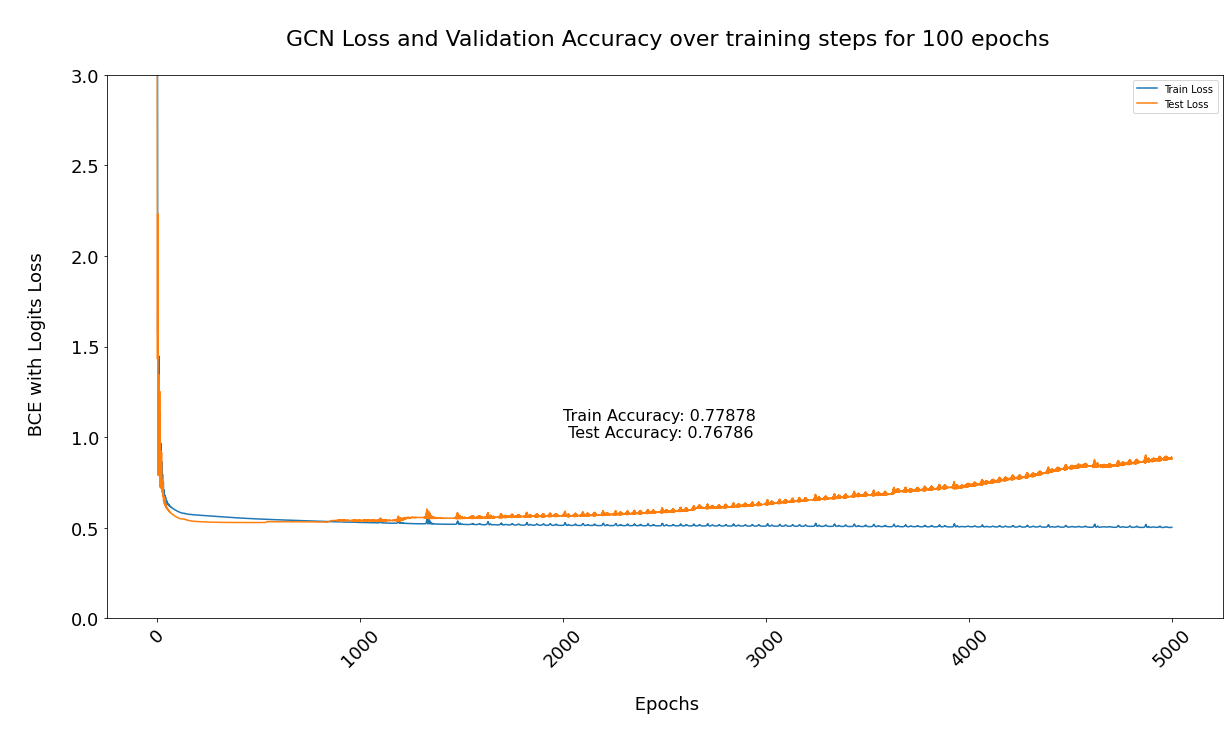

In [71]:

# Helper function
def sigmoid(x):
  """Sigmoid helper function for computing the accuracy by hand"""
  return 1 / (1 + torch.exp(-x))

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

start = time.time()

num_classes = int(max(train_labels))
hidden_size = 64
in_features = train_features.size()[1]
layers = 2
lr = 0.001
norm = False

n_epochs = 5000

gclassifier = GraphClassifier_tune(in_features, hidden_size, num_classes, normalize = norm, no_layers = layers)
optimizer = torch.optim.Adam(gclassifier.parameters(), lr=lr)
loss_fn = torch.nn.BCEWithLogitsLoss()

# Move to GPU
gclassifier.to(device)
train_a_norm = train_a_norm.to(device)
train_features = train_features.to(device)
train_batch_idx = train_batch_idx.to(device) 
train_labels = train_labels.to(device)
test_a_norm = test_a_norm.to(device)
test_features = test_features.to(device)
test_batch_idx = test_batch_idx.to(device) 
test_labels = test_labels.to(device)
train_losses = []
test_losses = []

# Run Training Loop
for epoch in range(n_epochs):

  # Zero gradients for every batch
  optimizer.zero_grad()

  # Make predictions for this batch
  pred = gclassifier.forward(train_features, train_a_norm, train_batch_idx.type(torch.int64))

  # Compute the loss and its gradients
  loss = loss_fn(pred, train_labels)
  loss.backward()

  # Adjust learning weights
  optimizer.step()
  train_losses.append(loss.item())

  # Calculate Train accuracy
  correct = (sigmoid(pred).round() == train_labels).sum()
  accuracy = correct / len(train_labels)

  # Calculate Test accuracy
  pred_test = gclassifier.forward(test_features, test_a_norm, test_batch_idx.type(torch.int64))
  test_loss = loss_fn(pred_test, test_labels)
  test_correct = (sigmoid(pred_test).round() == test_labels).sum()
  test_accuracy = test_correct / len(test_labels)
  test_losses.append(test_loss.item())

print(f'GCN Layers: {layers}, Hidden dim: {hidden_size}, LR: {lr}, Normalize: {norm} \n- Running loss: {round(loss.item(),7)}, Train Accuracy: {round(accuracy.item(),5)}, Test Accuracy: {round(test_accuracy.item(),5)} \n')

stop = time.time()

print(f"time needed: {stop - start}")

plt.figure(figsize=(20,10))
plt.plot(list(range(len(train_losses))), train_losses, label='Train Loss')
plt.plot(list(range(len(test_losses))), test_losses, label='Test Loss')
plt.title('Average training loss and validation accuracy per epoch')
plt.title("\n GCN Loss and Validation Accuracy over training steps for 100 epochs\n", size = 22)
plt.ylabel("\n BCE with Logits Loss\n", size = 18)
plt.xlabel("\n Epochs\n", size = 18)
plt.xticks(size = 18, rotation = 45)
plt.yticks(size = 18)
plt.ylim(0,3)
plt.annotate(f"Train Accuracy: {round(accuracy.item(),5)} \n Test Accuracy: {round(test_accuracy.item(),5)}", xy = (2000, 1), size = 16)
plt.legend()
plt.show()


 The final accuracy obtained in the independent testset unfortunately did not attain a competitive level with a test accuracy of 76,786%. This performance lies above the state of the art from 2016, but below the state of the art from 2019. Based on the tuning using the validation set, we expected a higher performance, at least close to 80%. As evident in the loss plot (see above), the test loss starts to rise after around 1500 epochs, while the training loss keeps decreasing. This is a clear sign for overfitting the model to the training data. Thus, it might be best to train the GCNs for a smaller amount of epochs, in order to avoid overfitting on the training set. However, in order to preserve good scientific practice, we did not try to optimize based on the test accuracy, but rather accept the results as they are. 

## The end

If you have made it all the way here successfully, congratulations! 🎉 

You have implemented your own GCN and tested it on a node classification task, and a more challenging classification task over multiple graphs.

We hope you can use this knowledge to apply GCNs not only to the tasks described here, but other applications where data can be modeled as a graph.

If you are interested in applying graph neural networks to larger graphs, or try newer architectures, you can dive deeper into [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), a library with fast implementations for a wide range of architectures. It also comes with custom code that takes care of aspects that you dealt with manually for this assignment, like a more efficient implementation of the adjacency matrix multiplication via message-passing methods, and Data Loaders that relieve you from having to build block diagonal sparse matrices.

You can also check the [Deep Graph Library](https://docs.dgl.ai/) another powerful library for deep learning on graphs which also integrates with other backends like TensorFlow.

# Grading (10pt)

- Question 1: 0.25pt 
- Question 2: 0.25pt 
- Question 3: 0.5pt 
- Question 4: 0.25pt 
- Question 5: 0.5pt 
- Question 6: 0.5pt 
- Question 7: 0.5pt 
- Question 8: 0.5pt 
- Question 9: 1.5pt 
- Question 10: 0.5pt 
- Question 11: 0.25pt 
- Question 12: 0.5pt 
- Question 13: 0.5pt 
- Question 14: 1pt
- Question 15: 1pt
- Question 16: 1.5pt